Inspriation: [Quelle](https://nzlul.medium.com/the-classification-of-text-messages-using-lstm-bi-lstm-and-gru-f79b207f90ad)<br>
Daten: [Quelle](https://github.com/kitsamho/songlyrics_univeral_sentence_encoder/tree/master/Lyric_data)


## Imports

In [55]:
#%conda install pip
# %pip install -r requirements.txt
# Load, explore and plot data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import to_categorical


import nltk
from nltk.corpus import stopwords
import re

######## SEED setzen
import random
# Random Seed setzen:
SEED = 49
random.seed(SEED)
np.random.seed(SEED)



label_encoder = LabelEncoder()

## Load Data

In [56]:
load_df = pd.read_csv('preprocessed_single_label.csv', encoding='ISO-8859-1')
load_df.head(3)

,Unnamed: 0,Titel,Lyric,Artist,Genres
0,1719,I Miss Her,oh lord id like know thinks oh oh lord wanna g...,Olodum,AxÃ©
1,1766,They Don't Care About Us,skin head dead head everybody gone bad situati...,Olodum,AxÃ©
2,2586,Loved You Right Away,moment saw minute met wonderful feeling never ...,Carlinhos Brown,AxÃ©


In [68]:
load_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42760 entries, 0 to 42759
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  42760 non-null  int64 
 1   Titel       42758 non-null  object
 2   Lyric       42758 non-null  object
 3   Artist      42760 non-null  object
 4   Genres      42760 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


Lyrics (Data) und Genere (Label) haben keinen Nullwert. Song (-Titel) fehelen 6 aber dass ist egal die können ignoriert werden.

In [58]:
load_df.describe()

,Unnamed: 0
count,42760.000000
mean,211707.664897
std,105389.229828
min,1719.000000
25%,156391.750000
50%,205412.500000
75%,303387.250000
max,378865.000000


Funktion zum Plotten der Modell History

Text(0.5, 1.0, 'The distribution of genres')

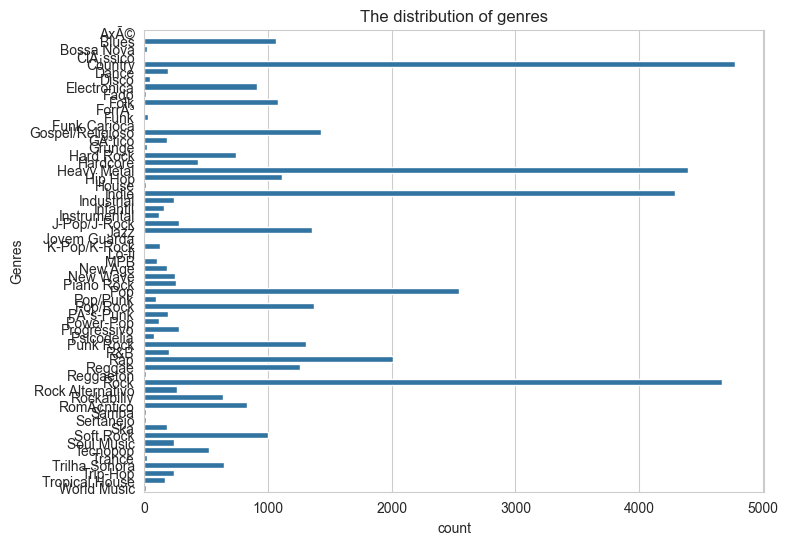

In [59]:
plt.figure(figsize=(8,6))
sns.countplot(load_df.Genres)
plt.title('The distribution of genres')

Genres sehen erst Mal relativ gleichmäßig verteilt aus. Eventuell Später alle auf die ANzahl vom niedrigsten (Hip-Hop) kürzen 

Erstellen des numerischen Labels aus den Genres: 

In [66]:
import pandas as pd

# Assuming the DataFrame 'load_df' is already loaded as you described
# Find the five most common genres
top_genres = load_df['Genres'].value_counts().nlargest(15).index

# Filter the DataFrame to only include rows with the top five genres
df = load_df[load_df['Genres'].isin(top_genres)]

# Now df_top_genres contains only the rows where the genre is one of the top five
print(df['Genres'].value_counts())

Genres
Country             4774
Rock                4672
Heavy Metal         4394
Indie               4289
Pop                 2544
Rap                 2012
Gospel/Religioso    1431
Pop/Rock            1374
Jazz                1356
Punk Rock           1310
Reggae              1255
Hip Hop             1112
Folk                1078
Blues               1063
Soft Rock           1003
Name: count, dtype: int64


In [69]:
# Conversion to string
df.loc[:, 'Titel'] = df['Titel'].astype(str)
df.loc[:, 'Lyric'] = df['Lyric'].astype(str)
df.loc[:, 'Artist'] = df['Artist'].astype(str)

# Count the number of words in the 'Lyric' column and normalize
df.loc[:, 'lyric_count'] = df['Lyric'].str.split().str.len()
df.loc[:, 'lyric_count_norm'] = df['lyric_count'] / df['lyric_count'].max() * 55

#df.head()
#df.info()

In [70]:
import pandas as pd

# Assuming df is your DataFrame
# Calculate average lyric counts per genre
average_lyric_counts = df.groupby('Genres')['lyric_count'].mean()

print(average_lyric_counts.sort_values())

Genres
Jazz                 74.430678
Gospel/Religioso     90.320755
Punk Rock            92.915267
Indie                94.822336
Blues                95.802446
Heavy Metal          98.178880
Soft Rock           100.909272
Folk                103.115955
Rock                108.330693
Country             109.321324
Pop/Rock            123.070597
Reggae              140.555378
Pop                 151.726415
Hip Hop             289.320144
Rap                 301.475149
Name: lyric_count, dtype: float64


In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# Vectorize the lyrics
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['Lyric'])

# Cluster the genres
num_clusters = 5  # Adjust based on how many genres you have or want to analyze
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
labels = kmeans.fit_predict(X)

# Map genres to clusters
df['Cluster'] = labels
clusters = df.groupby(['Genres', 'Cluster']).size().unstack(fill_value=0)
print(clusters)


Cluster              0    1    2     3     4
Genres                                      
Blues              329   88  374   146   126
Country           2637  522  305   868   442
Folk               706   82   48   167    75
Gospel/Religioso  1035  135   58   149    54
Heavy Metal       3577   82   91   434   210
Hip Hop            188   44   50   103   727
Indie             2461  217  264  1020   327
Jazz               767  236   83   182    88
Pop                813  280  357   771   323
Pop/Rock           532  158  103   469   112
Punk Rock          763   27   60   320   140
Rap                295   33   71   122  1491
Reggae             782  114   87   205    67
Rock              2561  361  441   939   370
Soft Rock          536  144   76   179    68


C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\631686019.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = labels


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 33667 samples in 0.031s...
[t-SNE] Computed neighbors for 33667 samples in 8.336s...
[t-SNE] Computed conditional probabilities for sample 1000 / 33667
[t-SNE] Computed conditional probabilities for sample 2000 / 33667
[t-SNE] Computed conditional probabilities for sample 3000 / 33667
[t-SNE] Computed conditional probabilities for sample 4000 / 33667
[t-SNE] Computed conditional probabilities for sample 5000 / 33667
[t-SNE] Computed conditional probabilities for sample 6000 / 33667
[t-SNE] Computed conditional probabilities for sample 7000 / 33667
[t-SNE] Computed conditional probabilities for sample 8000 / 33667
[t-SNE] Computed conditional probabilities for sample 9000 / 33667
[t-SNE] Computed conditional probabilities for sample 10000 / 33667
[t-SNE] Computed conditional probabilities for sample 11000 / 33667
[t-SNE] Computed conditional probabilities for sample 12000 / 33667
[t-SNE] Computed conditional probabilities for sa

C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\3777822597.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne-2d-one'] = tsne_results[:,0]
C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\3777822597.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsne-2d-two'] = tsne_results[:,1]
C:\Users\herbe\AppData\Local\Temp\ipykernel_19436\3777822597.py:14: UserWarning: 
The palette list has fewer values (5) than needed (15) and will cycle, which may produce an uninterpretable plot.
  sns.scatter

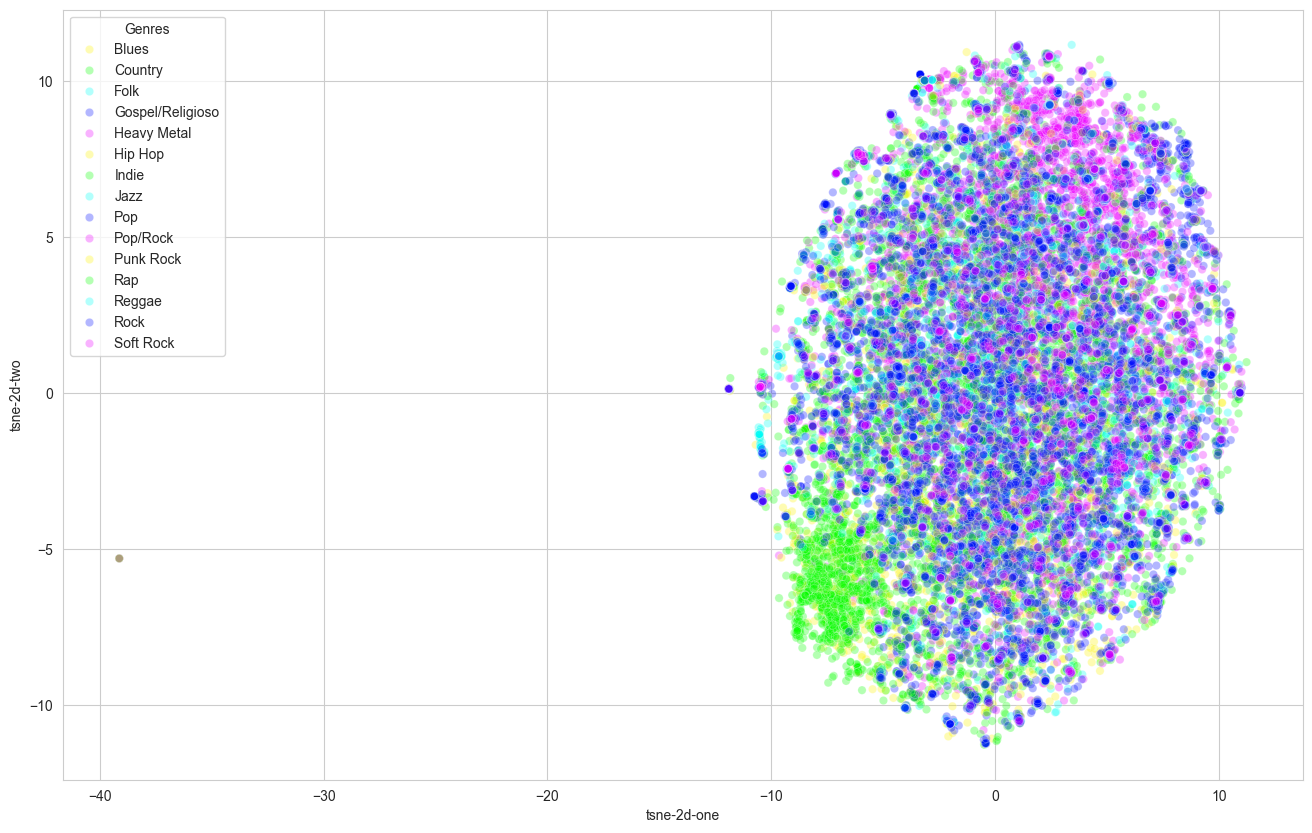

In [72]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

# Reduce dimensions
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X.toarray())

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]


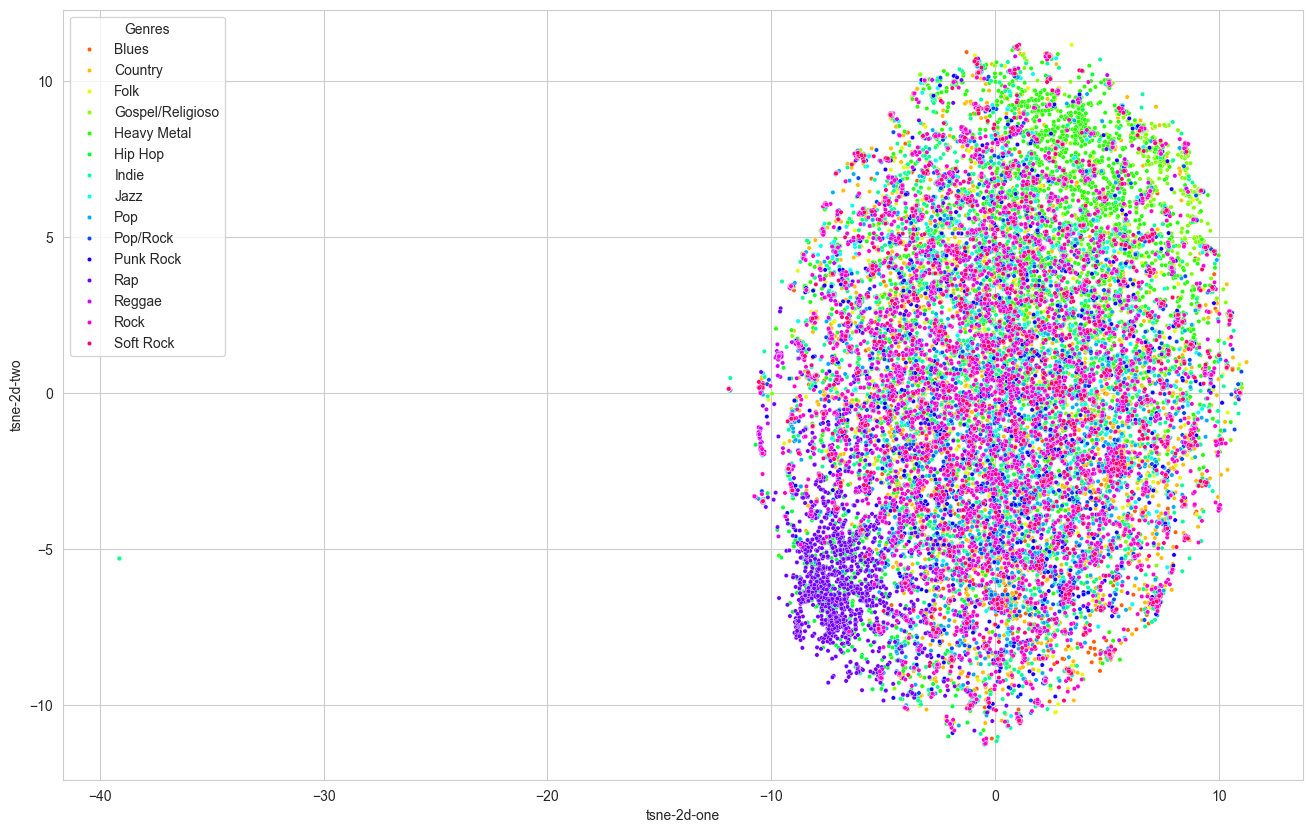

In [77]:

# Plot
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="Genres",
    palette=sns.color_palette("hsv", 15),
    data=df,
    legend="full",
    s=10 ,
    alpha=1
)
plt.show()

In [61]:
import pandas as pd

# Assuming the DataFrame 'df' is already loaded as you described
# Specify the genres to drop
genres_to_keep = ['Gospel/Religioso', 'Jazz', 'Pop/Rock', 'Rock', 'Pop', 'Rap', 'Punk Rock']
#genres_to_keep = ['Rock', 'Pop', 'HeavyMetal', 'HipHop', 'Indie', 
#                  'Romântico', 'HardRock', 'Rap', 'R&B', 'RockAlternativo']

# Drop rows where the genre column is in the genres_to_drop list
df = df[df['Genres'].isin(genres_to_keep)]

# Now df_filtered contains only the rows where genre is not 'alternative', 'r&b', 'pop/rock', or 'rock'
print(df['Genres'].value_counts())

Genres
Rock                4672
Pop                 2544
Rap                 2012
Gospel/Religioso    1431
Pop/Rock            1374
Jazz                1356
Punk Rock           1310
Name: count, dtype: int64


In [63]:
# Conversion to string
df.loc[:, 'Titel'] = df['Titel'].astype(str)
df.loc[:, 'Lyric'] = df['Lyric'].astype(str)
df.loc[:, 'Artist'] = df['Artist'].astype(str)

# Count the number of words in the 'Lyric' column and normalize
df.loc[:, 'lyric_count'] = df['Lyric'].str.split().str.len()
df.loc[:, 'lyric_count_norm'] = df['lyric_count'] / df['lyric_count'].max() * 55

#df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14699 entries, 8150 to 37975
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        14699 non-null  int64  
 1   Titel             14699 non-null  object 
 2   Lyric             14699 non-null  object 
 3   Artist            14699 non-null  object 
 4   Genres            14699 non-null  object 
 5   lyric_count       14699 non-null  int64  
 6   lyric_count_norm  14699 non-null  float64
dtypes: float64(1), int64(2), object(4)
memory usage: 918.7+ KB


In [44]:
# Ensure NLTK resources are downloaded
import nltk
nltk.download('stopwords')
# Functions to clean lyrics and remove repetitions
from nltk.corpus import stopwords
import re

def remove_repetitions(text):
    words = text.split()
    return ' '.join(sorted(set(words), key=words.index))

def clean_lyrics(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return remove_repetitions(text)

# Clean lyrics using
df.loc[:, 'Lyric'] = df['Lyric'].apply(clean_lyrics)

# Encoding labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df.loc[:, 'label'] = label_encoder.fit_transform(df['Genres'])



import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack

# Load your data
# df = pd.read_csv('path_to_your_data.csv')

# Assuming the DataFrame 'df' is already loaded as you described
# Preprocessing and vectorization of text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 3))
X_text = vectorizer.fit_transform(df['Lyric'])

# Adding the normalized lyric count as a feature
X_numeric = df[['lyric_count_norm']].values

# Combining text and numeric features
X_combined = hstack([X_text, X_numeric])

# Labels
y = df['Genres']


# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestClassifier(n_estimators=100,class_weight='balanced', random_state=SEED)
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))
print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\herbe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                  precision    recall  f1-score   support

Gospel/Religioso       0.79      0.66      0.72       299
            Jazz       0.77      0.54      0.63       273
             Pop       0.59      0.46      0.52       520
        Pop/Rock       0.74      0.36      0.48       267
       Punk Rock       0.85      0.13      0.23       252
             Rap       0.91      0.88      0.89       426
            Rock       0.49      0.82      0.61       903

        accuracy                           0.62      2940
       macro avg       0.73      0.55      0.58      2940
    weighted avg       0.68      0.62      0.60      2940

Accuracy: 0.62


In [50]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack
from imblearn.over_sampling import SMOTE
from textblob import TextBlob

# Ensure NLTK resources are downloaded
nltk.download('stopwords', quiet=True)

def remove_repetitions(text):
    words = text.split()
    return ' '.join(sorted(set(words), key=words.index))

def clean_lyrics(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    stop_words = set(stopwords.words('english'))
    return ' '.join(word for word in text.split() if word not in stop_words)

def get_sentiment(text):
    # Calculate sentiment polarity using TextBlob
    return TextBlob(text).sentiment.polarity

def train_genre_classifier(df, SEED=42):
    # Conversion to string
    df.loc[:, 'Titel'] = df['Titel'].astype(str)
    df.loc[:, 'Lyric'] = df['Lyric'].astype(str)
    df.loc[:, 'Artist'] = df['Artist'].astype(str)

    # Clean lyrics and calculate sentiment
    df.loc[:, 'Lyric'] = df['Lyric'].apply(clean_lyrics)
    df.loc[:, 'sentiment'] = df['Lyric'].apply(get_sentiment)

    # Count the number of words in the 'Lyric' column and normalize
    df.loc[:, 'lyric_count'] = df['Lyric'].str.split().str.len()
    df.loc[:, 'lyric_count_norm'] = df['lyric_count'] / df['lyric_count'].max()

    # Encoding labels
    label_encoder = LabelEncoder()
    df.loc[:, 'label'] = label_encoder.fit_transform(df['Genres'])

    # Preprocessing and vectorization of text data
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1, 3))
    X_text = vectorizer.fit_transform(df['Lyric'])

    # Adding the normalized lyric count and sentiment as features
    X_numeric = df[['lyric_count_norm', 'sentiment']].values

    # Combining text and numeric features
    X_combined = X_numeric

    # Labels
    y = df['Genres']

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=SEED)

    # Apply SMOTE for class balancing in the training set
    smote = SMOTE(random_state=SEED)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Model training
    model = RandomForestClassifier(n_estimators=100, random_state=SEED)
    model.fit(X_train_resampled, y_train_resampled)

    # Model evaluation
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions))
    print(f'Accuracy: {accuracy_score(y_test, predictions):.2f}')

    return accuracy_score(y_test, predictions)  # Optionally return this if you need it for further processing

# Example of using the function
# df = pd.read_csv('path_to_your_data.csv')
accuracy = train_genre_classifier(df)


                  precision    recall  f1-score   support

Gospel/Religioso       0.22      0.21      0.22       299
            Jazz       0.27      0.34      0.30       273
             Pop       0.21      0.18      0.20       520
        Pop/Rock       0.12      0.14      0.13       267
       Punk Rock       0.13      0.15      0.14       252
             Rap       0.77      0.81      0.79       426
            Rock       0.38      0.35      0.36       903

        accuracy                           0.34      2940
       macro avg       0.30      0.31      0.31      2940
    weighted avg       0.34      0.34      0.34      2940

Accuracy: 0.34
